# Semantic embedding network creation

In [6]:
import networkx as nx
from pathlib import Path
import torch
from sentence_transformers import SentenceTransformer
import numpy as np
import json 

# --- 1. SETUP PATHS ---
input_path = Path(r"C:\Users\Madsl\Dropbox\DTU\Kand\2.semester\Socialgraphs_and_interactions\SocialGraphs\SocialGraphs\Project\MUSIC\artist_network_with_sentiment.graphml")
# We will save to a new file to avoid overwriting your original while testing
output_path = input_path.parent / "artist_network_with_embeddings.graphml"

print("Loading graph...")
G = nx.read_graphml(str(input_path))

# --- 2. SETUP AI ---
def get_device():
    if torch.cuda.is_available(): return "cuda"
    if torch.backends.mps.is_available(): return "mps"
    return "cpu"

device = get_device()
print(f"Running on: {device}")
model = SentenceTransformer('all-MiniLM-L6-v2', device=device)

# --- 3. PREPARE DATA ---
node_ids = []
lyrics_list = []

print("Gathering lyrics...")
for node in G.nodes():
    # Fetch lyrics
    raw_text = str(G.nodes[node].get('lyrics', ''))
    
    # Filter valid lyrics
    if len(raw_text) > 5:
        node_ids.append(node)
        lyrics_list.append(raw_text[:2000]) # Truncate for speed/memory

print(f"Nodes to embed: {len(node_ids)}")

# --- 4. ENCODE & STORE IN GRAPH ---
if len(node_ids) > 0:
    print("Generating embeddings (this happens only once now)...")
    embeddings = model.encode(lyrics_list, show_progress_bar=True, device=device)
    
    print("Attaching vectors to nodes...")
    count = 0
    for node, emb in zip(node_ids, embeddings):
        # IMPORTANT: GraphML cannot save numpy arrays directly.
        # We convert the numpy array to a list, and then to a JSON string.
        # Example: "[0.123, -0.456, ...]"
        G.nodes[node]['lyric_vector'] = json.dumps(emb.tolist())
        count += 1
        
    print(f"Successfully added vectors to {count} nodes.")

    # --- 5. SAVE GRAPH ---
    print(f"Saving new graph to: {output_path}")
    nx.write_graphml(G, str(output_path))
    print("Done! You can now load this file in other scripts without re-running the AI.")

else:
    print("No lyrics found to embed.")

c:\Users\Madsl\anaconda3\envs\lyrics_project\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading graph...
Running on: cpu
Gathering lyrics...
Nodes to embed: 983
Generating embeddings (this happens only once now)...


Batches: 100%|██████████| 31/31 [00:39<00:00,  1.28s/it]


Attaching vectors to nodes...
Successfully added vectors to 983 nodes.
Saving new graph to: C:\Users\Madsl\Dropbox\DTU\Kand\2.semester\Socialgraphs_and_interactions\SocialGraphs\SocialGraphs\Project\MUSIC\artist_network_with_embeddings.graphml
Done! You can now load this file in other scripts without re-running the AI.


# Read semantic embedding and convert to vector

In [ ]:
import networkx as nx
import json
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Load the file we just created
G = nx.read_graphml("artist_network_with_embeddings.graphml")

# Example: Get vector for a specific node
node_id = list(G.nodes())[0]

if 'lyric_vector' in G.nodes[node_id]:
    # 1. Get the string
    vector_str = G.nodes[node_id]['lyric_vector']
    
    # 2. Convert String -> List -> Numpy Array
    vector = np.array(json.loads(vector_str))
    
    print(f"Node: {node_id}")
    print(f"Vector Shape: {vector.shape}")
    
    # Now you can use it for cosine similarity immediately:
    # sim = cosine_similarity([vector], [other_vector])

# Plot for semantic similarity

Reloading graph to ensure lyrics are present...
Debug Check - Node: Missy_Elliott
Debug Check - Has Lyrics? True
Running on: cpu
Gathering lyrics...
Nodes sent to AI: 983
Encoding...


Batches: 100%|██████████| 31/31 [00:42<00:00,  1.36s/it]


Comparing edges...


100%|██████████| 16333/16333 [00:04<00:00, 3355.41it/s]


✨ Pearson Correlation: 0.1642


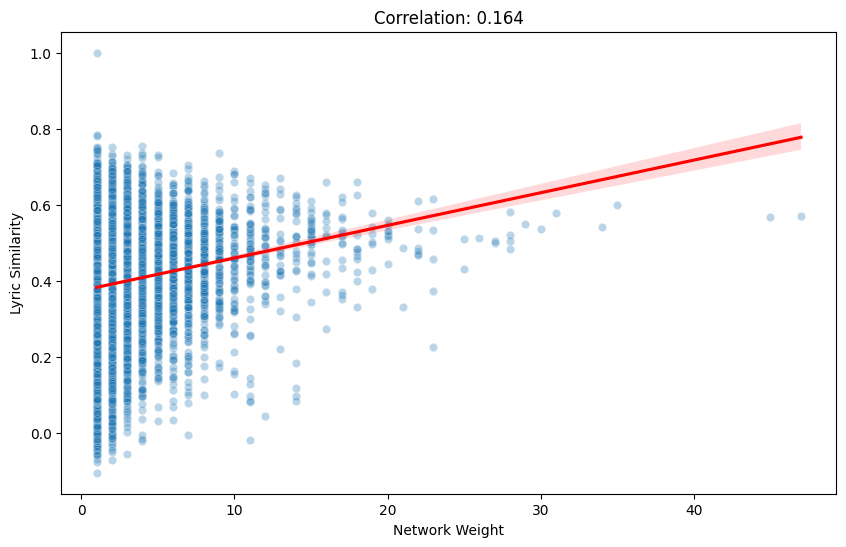

In [ ]:
import networkx as nx
from pathlib import Path
import torch
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# --- 1. RELOAD DATA (To ensure we have lyrics) ---
# Update this path if needed
G_path = Path(r"C:\Users\Madsl\Dropbox\DTU\Kand\2.semester\Socialgraphs_and_interactions\SocialGraphs\SocialGraphs\Project\MUSIC\artist_network_with_sentiment.graphml")

print("Reloading graph to ensure lyrics are present...")
G = nx.read_graphml(str(G_path))

# # --- 2. CREATE A CORRECT TEST SLICE ---
# # We take the first 200 nodes, but use .subgraph() to KEEP the lyrics
# print("Creating a small test graph (preserving attributes)...")
# test_nodes = list(G_full.nodes())[:200]
# G = G_full.subgraph(test_nodes).copy()

# Check one node to be 100% sure
first_node = list(G.nodes())[0]
print(f"Debug Check - Node: {first_node}")
print(f"Debug Check - Has Lyrics? {'lyrics' in G.nodes[first_node]}")

# --- 3. SETUP AI ---
def get_device():
    if torch.cuda.is_available(): return "cuda"
    if torch.backends.mps.is_available(): return "mps"
    return "cpu"

device = get_device()
print(f"Running on: {device}")
model = SentenceTransformer('all-MiniLM-L6-v2', device=device)

# --- 4. PREPARE LYRICS ---
node_ids = []
lyrics_list = []

print("Gathering lyrics...")
for node in G.nodes():
    # Fetch lyrics, convert to string safely
    raw_text = str(G.nodes[node].get('lyrics', ''))
    
    # Check length (str(None) is 4 chars, so >5 filters out empty/None)
    if len(raw_text) > 5:
        node_ids.append(node)
        lyrics_list.append(raw_text[:2000])

print(f"Nodes sent to AI: {len(node_ids)}")

if len(node_ids) == 0:
    raise ValueError("Still no lyrics! Check the 'Debug Check' print above.")

# --- 5. ENCODE & ANALYZE ---
print("Encoding...")
embeddings = model.encode(lyrics_list, show_progress_bar=True, device=device)
embedding_dict = {node: emb for node, emb in zip(node_ids, embeddings)}

print("Comparing edges...")
data_points = []

for u, v, data in tqdm(G.edges(data=True)):
    if u in embedding_dict and v in embedding_dict:
        sim = cosine_similarity([embedding_dict[u]], [embedding_dict[v]])[0][0]
        
        data_points.append({
            'Network Weight': data['weight'], 
            'Lyric Similarity': sim
        })

# --- 6. PLOT ---
df = pd.DataFrame(data_points)

if not df.empty:
    corr = df['Network Weight'].corr(df['Lyric Similarity'])
    print(f"✨ Pearson Correlation: {corr:.4f}")

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='Network Weight', y='Lyric Similarity', alpha=0.3)
    sns.regplot(data=df, x='Network Weight', y='Lyric Similarity', scatter=False, color='red')
    plt.title(f"Correlation: {corr:.3f}")
    plt.show()
else:
    print("Not enough edges in this small test slice to plot.")

In [7]:
# --- REBUILD DATAFRAME WITH NAMES ---
print("Re-building dataframe with artist names...")
data_points = []

# Re-run just the comparison loop (very fast, no AI involved)
for u, v, data in tqdm(G.edges(data=True)):
    if u in embedding_dict and v in embedding_dict:
        # We assume cosine_similarity is imported
        # If you get an error, re-import sklearn
        from sklearn.metrics.pairwise import cosine_similarity
        
        sim = cosine_similarity(
            [embedding_dict[u]], 
            [embedding_dict[v]]
        )[0][0]
        
        data_points.append({
            'Artist A': u,
            'Artist B': v,  # <--- Adding names back in!
            'Network Weight': data['weight'], 
            'Lyric Similarity': sim
        })

df = pd.DataFrame(data_points)

# --- NOW FIND THE COUPLES ---
weirdest_pair = df[df['Network Weight'] > 4].sort_values('Lyric Similarity').head(1)
best_match = df[df['Network Weight'] > 4].sort_values('Lyric Similarity', ascending=False).head(1)

print("\n--- THE WEIRDEST COUPLE (High Co-occurrence, Different Lyrics) ---")
print(weirdest_pair[['Artist A', 'Artist B', 'Network Weight', 'Lyric Similarity']].to_string(index=False))

print("\n--- THE PERFECT MATCH (High Co-occurrence, Similar Lyrics) ---")
print(best_match[['Artist A', 'Artist B', 'Network Weight', 'Lyric Similarity']].to_string(index=False))

Re-building dataframe with artist names...


100%|██████████| 16333/16333 [00:04<00:00, 3338.00it/s]


--- THE WEIRDEST COUPLE (High Co-occurrence, Different Lyrics) ---
  Artist A      Artist B  Network Weight  Lyric Similarity
Bruno_Mars Calvin_Harris              11         -0.019096

--- THE PERFECT MATCH (High Co-occurrence, Similar Lyrics) ---
 Artist A   Artist B  Network Weight  Lyric Similarity
Meek_Mill Young_Thug               9          0.736827


# Nuanced sentiment

Reloading graph...
Recalculating sentiment (Line-by-Line Average)...


100%|██████████| 1004/1004 [00:54<00:00, 18.27it/s]


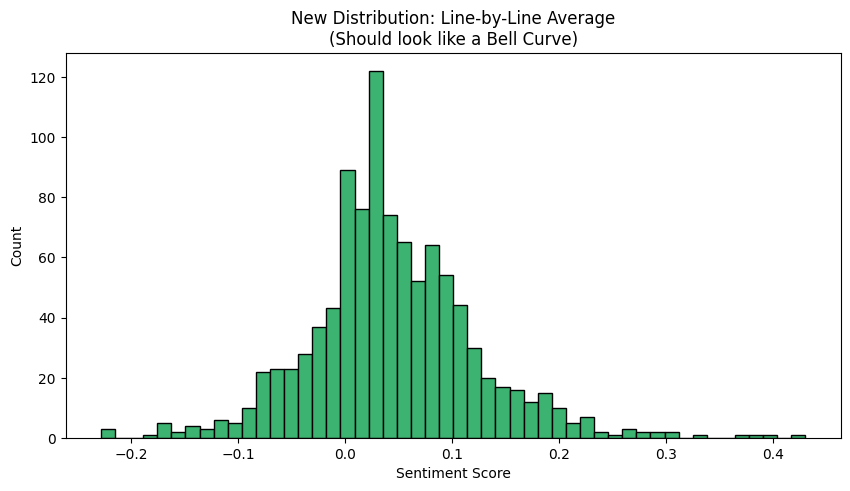

Saved to C:\Users\Madsl\Dropbox\DTU\Kand\2.semester\Socialgraphs_and_interactions\SocialGraphs\SocialGraphs\Project\MUSIC\artist_network_nuanced_sentiment.graphml


In [3]:
import networkx as nx
import numpy as np
# from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# --- 1. SETUP ---
analyzer = SentimentIntensityAnalyzer()
G_path = Path(r"C:\Users\Madsl\Dropbox\DTU\Kand\2.semester\Socialgraphs_and_interactions\SocialGraphs\SocialGraphs\Project\MUSIC\artist_network_with_sentiment.graphml")

print("Reloading graph...")
G = nx.read_graphml(str(G_path))

# --- 2. THE NEW CALCULATION METHOD ---
def get_nuanced_sentiment(text):
    if len(text) < 5: 
        return 0.0
    
    # Split into lines
    lines = text.split('\n')
    line_scores = []
    
    for line in lines:
        # Skip empty lines or very short garbage
        if len(line.strip()) > 2:
            # Get the compound score for JUST this line
            score = analyzer.polarity_scores(line)['compound']
            line_scores.append(score)
            
    if not line_scores:
        return 0.0
        
    # Return the average of the lines
    return np.mean(line_scores)

# --- 3. APPLY TO ALL NODES ---
print("Recalculating sentiment (Line-by-Line Average)...")
new_scores = []

for node in tqdm(G.nodes()):
    # Get raw lyrics
    lyrics = str(G.nodes[node].get('lyrics', ''))
    
    # Calculate new score
    new_score = get_nuanced_sentiment(lyrics)
    
    # Update the node attribute
    G.nodes[node]['sentiment_compound'] = float(new_score)
    new_scores.append(new_score)

# --- 4. CHECK THE NEW DISTRIBUTION ---
plt.figure(figsize=(10, 5))
plt.hist(new_scores, bins=50, color='mediumseagreen', edgecolor='black')
plt.title("New Distribution: Line-by-Line Average\n(Should look like a Bell Curve)")
plt.xlabel("Sentiment Score")
plt.ylabel("Count")
plt.show()

# --- 5. SAVE IF YOU LIKE IT ---
output_path = G_path.parent / "artist_network_nuanced_sentiment.graphml"
nx.write_graphml(G, str(output_path))
print(f"Saved to {output_path}")

# Sentiment

In [16]:
import community.community_louvain as community_louvain 
import networkx as nx
import pandas as pd
from pathlib import Path
from tqdm import tqdm # Import tqdm for progress bar
import matplotlib.pyplot as plt # Keep imports at the top
import seaborn as sns
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# 1. SETUP VADER
try:
    nltk.data.find('vader_lexicon')
except LookupError:
    nltk.download('vader_lexicon')
    
sia = SentimentIntensityAnalyzer()

# 2. GET COMMUNITIES (Loading the graph)
G_path = Path(r"C:\Users\Madsl\Dropbox\DTU\Kand\2.semester\Socialgraphs_and_interactions\SocialGraphs\SocialGraphs\Project\MUSIC\artist_network_NCbackbone_3.graphml")

print("Loading graph...")
# Rename to G for general use
G = nx.read_graphml(str(G_path)) 

# --- Community detection and filtering (optional for sentiment calculation, but kept for context) ---
print("Detecting communities (Louvain)...")
partition = community_louvain.best_partition(G, weight='weight')
from collections import Counter
counts = Counter(partition.values())
# Using a dummy list of all communities if we want to process ALL nodes, 
# or keep the big_communities filter if you only want to process a subset.
big_communities = [c for c, count in counts.items() if count > 50]
# -------------------------------------------------------------------------------------------------

# 3. CALCULATE SENTIMENT PER ARTIST AND ADD TO GRAPH
print("Analyzing sentiment and adding it to the graph...")

# Use G.nodes() for all nodes if you want to ensure every node gets the attribute
# If an artist is not in a big community or has no lyrics, their score will be 0 or NaN
for node in tqdm(G.nodes()):
    
    # Optional: Filter by community (remove if you want to process all nodes)
    # comm_id = partition.get(node)
    # if comm_id not in big_communities:
    #      # Skip nodes in small communities
    #      # We still need to set the attribute for all nodes if we want a clean graph save later
    #      G.nodes[node]['sentiment_compound'] = 0.0 # Assign neutral score or choose to set it to None/NaN
    #      continue
        
    # Get Lyrics
    text = str(G.nodes[node].get('lyrics', ''))
    
    # If we have lyrics, score them
    if len(text) > 50:
        score = sia.polarity_scores(text)['compound']
        
        # --- KEY STEP: Add the sentiment score as a new node attribute ---
        G.nodes[node]['sentiment_compound'] = score
        
    else:
        # Assign a neutral score or 0 if lyrics are missing or too short
        G.nodes[node]['sentiment_compound'] = 0.0
        
# --------------------------------------------------------------------------
# --- NEW STEP: SAVE THE MODIFIED GRAPH ---
# --------------------------------------------------------------------------

# Define the path for the new GraphML file
new_graph_path = G_path.parent / "artist_network_with_sentiment.graphml"

print(f"Saving new graph with sentiment attributes to: {new_graph_path}")

# Write the graph (which now includes the 'sentiment_compound' attribute on each node)
nx.write_graphml(G, str(new_graph_path))

print("Saving complete.")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Madsl\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Loading graph...
Detecting communities (Louvain)...
Analyzing sentiment and adding it to the graph...


100%|██████████| 1004/1004 [15:30<00:00,  1.08it/s] 


Saving new graph with sentiment attributes to: C:\Users\Madsl\Dropbox\DTU\Kand\2.semester\Socialgraphs_and_interactions\SocialGraphs\SocialGraphs\Project\MUSIC\artist_network_with_sentiment.graphml
Saving complete.


# Louvain 

Loading graph with pre-calculated sentiment...
Detecting communities (Louvain)...
Found 9 communities. Analyzing 6 major ones.
Extracting sentiment data...


100%|██████████| 1004/1004 [00:00<00:00, 195364.47it/s]
C:\Users\Madsl\AppData\Local\Temp\ipykernel_27344\579575847.py:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Community', y='Sentiment', data=df_sentiment, order=order, palette="vlag")


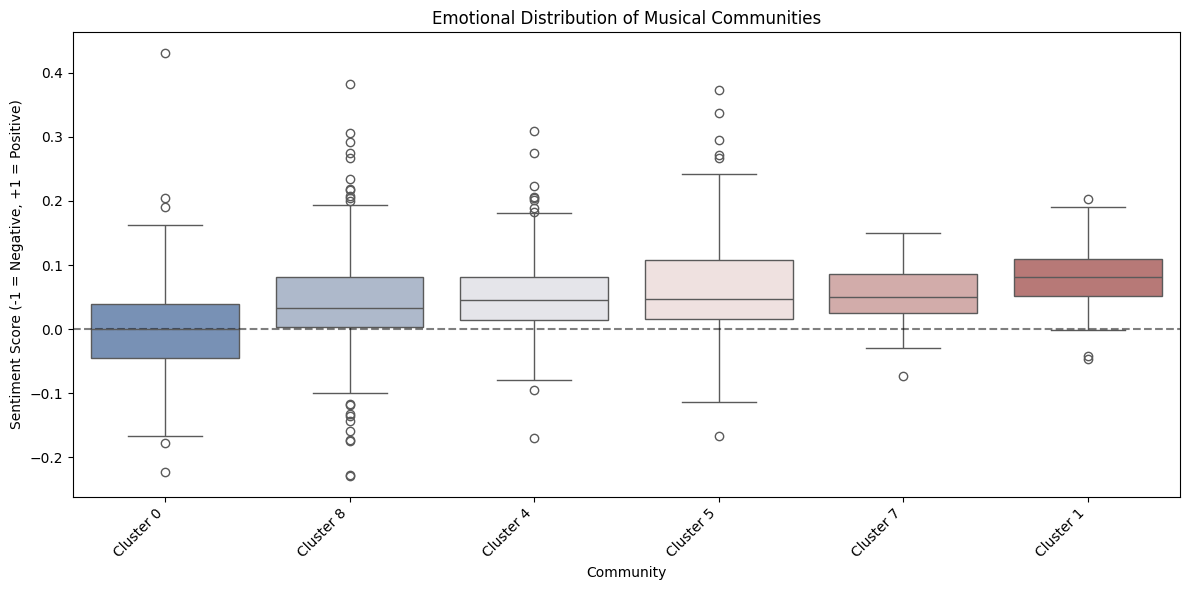


--- COMMUNITY EMOTIONAL PROFILES ---
           count      mean       std
Community                           
Cluster 0  130.0  0.002615  0.084966
Cluster 8  321.0  0.040979  0.077627
Cluster 4  145.0  0.053511  0.068086
Cluster 7   61.0  0.054690  0.045966
Cluster 5  184.0  0.061685  0.084762
Cluster 1   62.0  0.076892  0.048172


In [6]:
import community.community_louvain as community_louvain 
import networkx as nx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm # Import tqdm for progress bar
from collections import Counter
import networkx.algorithms.community as nx_comm 

# --- 1. Load the graph with pre-calculated sentiment ---
G_path = Path(r"C:\Users\Madsl\Dropbox\DTU\Kand\2.semester\Socialgraphs_and_interactions\SocialGraphs\SocialGraphs\Project\MUSIC\artist_network_nuanced_sentiment.graphml")

print("Loading graph with pre-calculated sentiment...")
G = nx.read_graphml(str(G_path)) 

# --- 2. Recalculate Communities and Filter ---
# We still need the community partition to group the artists for the box plot.
# Note: You can save the partition too, but recalculating is often simpler.
print("Detecting communities (Louvain)...")
partition = community_louvain.best_partition(G, weight='weight', random_state=5)




# Count how many artists in each community to filter out tiny ones
counts = Counter(partition.values())
# Keep only communities with at least 50 artists
big_communities = [c for c, count in counts.items() if count > 50]

print(f"Found {len(counts)} communities. Analyzing {len(big_communities)} major ones.")

# --- 3. Extract Data for Plotting ---
data = []

print("Extracting sentiment data...")
# Iterate over all nodes
for node in tqdm(G.nodes()):
    comm_id = partition.get(node)
    
    # Only process if node is in a big community
    if comm_id in big_communities:
        
        # --- KEY STEP: Retrieve the saved attribute ---
        # Note: networkx might load the attribute as a string, so we convert it to float
        sentiment_str = G.nodes[node].get('sentiment_compound')
        
        # Skip if the attribute is somehow missing or not a valid number (shouldn't happen if saved correctly)
        try:
            score = float(sentiment_str)
        except (TypeError, ValueError):
            continue 
            
        # Only add data points with a non-zero sentiment (optional, to remove the 0.0 placeholders)
        if score != 0.0:
            data.append({
                'Artist': node,
                'Community': f"Cluster {comm_id}",
                'Sentiment': score
            })

df_sentiment = pd.DataFrame(data)

if df_sentiment.empty:
    print("No relevant sentiment data found after filtering.")
else:
    # --- 4. Sort Communities by Median Sentiment ---
    order = df_sentiment.groupby('Community')['Sentiment'].median().sort_values().index

    # --- 5. VISUALIZE ---
    plt.figure(figsize=(12, 6))
    
    # Using 'vlag' palette for a nice blue-red gradient or 'RdBu' as in the original
    sns.boxplot(x='Community', y='Sentiment', data=df_sentiment, order=order, palette="vlag") 
    
    plt.title("Emotional Distribution of Musical Communities")
    plt.ylabel("Sentiment Score (-1 = Negative, +1 = Positive)")
    plt.xticks(rotation=45, ha='right') # Rotate and align for better readability
    plt.tight_layout() # Adjust plot to prevent labels from being cut off
    plt.axhline(0, color='black', linestyle='--', alpha=0.5) # The "Neutral" line
    plt.show()

    # --- 6. PRINT SUMMARY ---
    print("\n--- COMMUNITY EMOTIONAL PROFILES ---")
    stats = df_sentiment.groupby('Community')['Sentiment'].describe()[['count', 'mean', 'std']]
    print(stats.sort_values(by='mean'))

    # Create a dictionary to store lists of artists per cluster
cluster_members = {}
for node, comm_id in partition.items():
    if comm_id not in cluster_members:
        cluster_members[comm_id] = []
    cluster_members[comm_id].append(node)

# Function to get the most "central" artists in a cluster (highest degree)
def get_top_artists(comm_id, limit=5):
    nodes = cluster_members[comm_id]
    # Sort by degree (popularity in network)
    sorted_nodes = sorted(nodes, key=lambda n: G.degree(n), reverse=True)
    return sorted_nodes[:limit]



In [22]:
print("--- CLUSTER IDENTIFICATION ---")

# Check the Negative One
print(f"\nCluster 0 (The Negative One): {get_top_artists(0)}")

# Check the Mainstream One
print(f"\nCluster 8 (The Big One): {get_top_artists(8)}")

# Check the Happy One
print(f"\nCluster 1 (The Happy One): {get_top_artists(1)}")

--- CLUSTER IDENTIFICATION ---

Cluster 0 (The Negative One): ['Chance_The_Rapper', 'Skrillex', 'The_Offspring', 'Kid_Cudi', 'Childish_Gambino']

Cluster 8 (The Big One): ['Yeah_Yeah_Yeahs', 'Lana_Del_Rey', 'Coldplay', 'The_Shins', 'The_xx']

Cluster 1 (The Happy One): ['Little_Big_Town', 'Alan_Jackson', 'Thompson_Square', 'Blake_Shelton', 'Lady_Antebellum']


In [7]:
# communities_grouped = {}
# for node, comm_id in partition.items():
#     # If the community ID is seen for the first time, create a new set
#     if comm_id not in communities_grouped:
#         communities_grouped[comm_id] = set()
#     # Add the current node to its corresponding community set
#     communities_grouped[comm_id].add(node)

# # 2. Extract the sets of nodes (the values of the dictionary)
# # This is the format required by nx_comm.modularity: an iterable of sets of nodes
# communities_list_of_sets = list(communities_grouped.values())


# # Calculate the modularity using the correctly formatted communities
# modularity_score = nx_comm.modularity(G, communities_list_of_sets, weight='weight') 

# print(f"Modularity for the partition: {modularity_score:.4f}")

Modularity for the partition: 0.4994


Loading graph with pre-calculated sentiment...
Extracting sentiment scores for colors...
Calculating node degree for size...


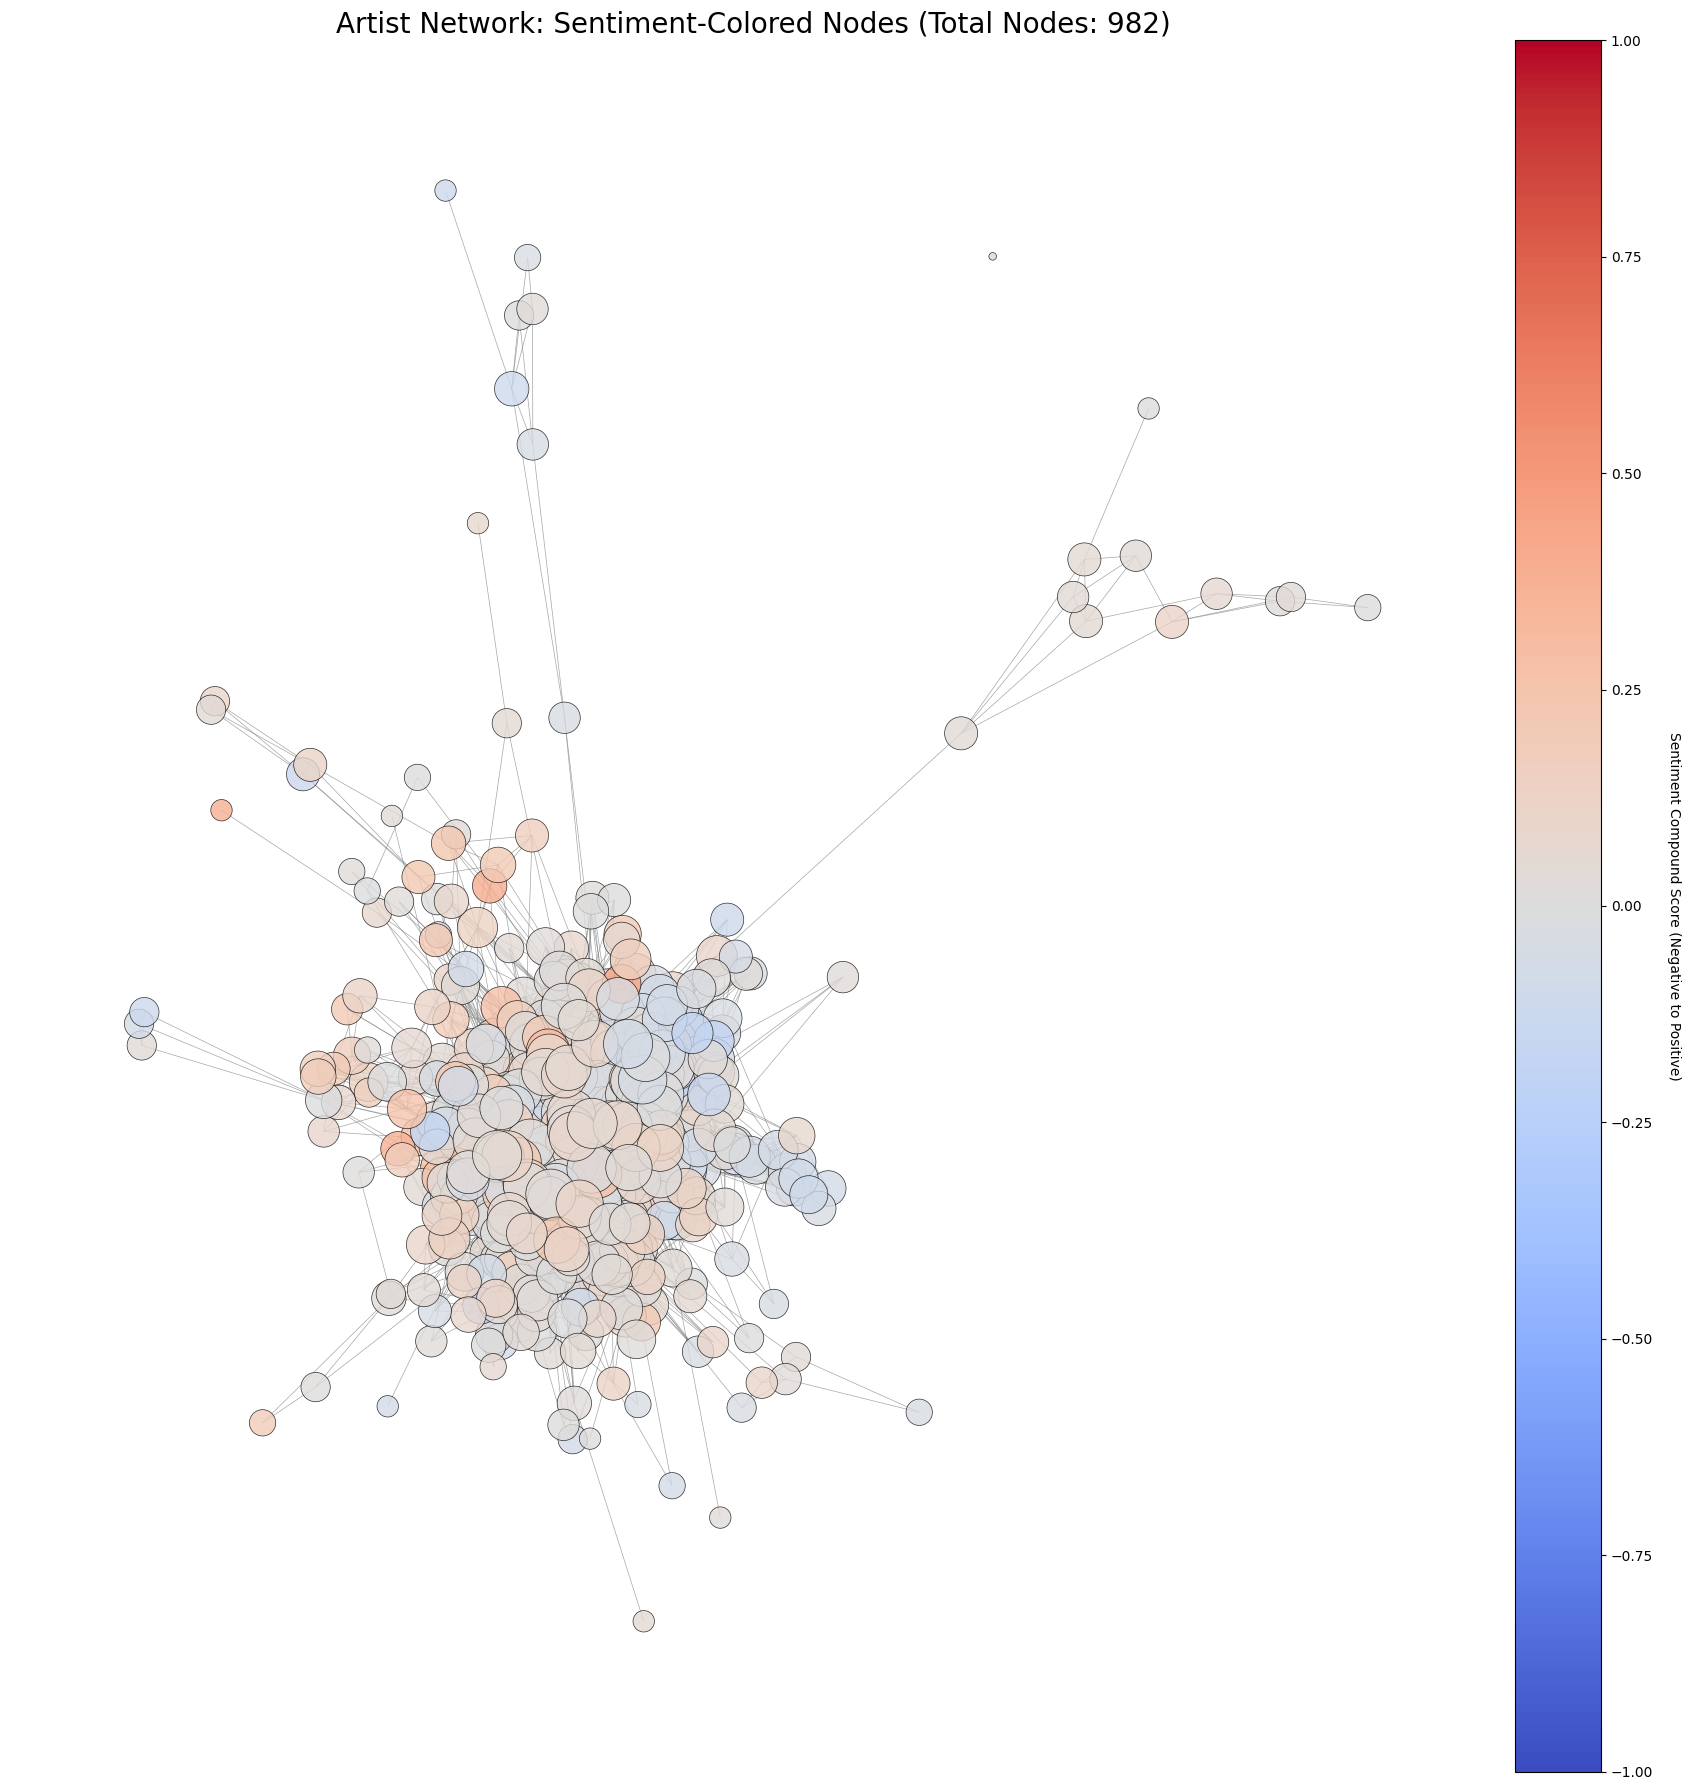

In [10]:
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path
import community.community_louvain as community_louvain 
from collections import Counter

# --- 1. Load the graph with pre-calculated sentiment ---
G_path = Path(r"C:\Users\Madsl\Dropbox\DTU\Kand\2.semester\Socialgraphs_and_interactions\SocialGraphs\SocialGraphs\Project\MUSIC\artist_network_nuanced_sentiment.graphml")

print("Loading graph with pre-calculated sentiment...")
G = nx.read_graphml(str(G_path)) 

# --- 2. Prepare Node Attributes for Drawing ---

# A. Sentiments for Node Colors
print("Extracting sentiment scores for colors...")
# Get sentiment and convert to float (GraphML often loads numbers as strings)
# We also filter out any nodes where the score might be missing or 0.0 (the placeholders) 
# to keep the visualization focused on scored artists.
sentiment_map = {}
for node, data in G.nodes(data=True):
    try:
        score = float(data.get('sentiment_compound', 0.0))
        # Only include nodes that had actual lyrics (score != 0.0 placeholder)
        if score != 0.0:
            sentiment_map[node] = score
    except (TypeError, ValueError):
        continue

# Create a sub-graph with only the nodes that have a valid sentiment score
nodes_to_draw = list(sentiment_map.keys())
G_sub = G.subgraph(nodes_to_draw).copy()

# Create the list of sentiment scores in the order of the nodes in the subgraph
node_sentiment_colors = [sentiment_map[node] for node in G_sub.nodes()]


# B. Degree for Node Size
print("Calculating node degree for size...")
# Calculate the degree (or weighted degree) of each node
# Use degree for unweighted, or sum of weights for weighted degree
degree_map = dict(G_sub.degree()) 

# Scale the degree values for better visualization (e.g., 50 * log(degree))
# Using log transform helps prevent huge size differences
import numpy as np
base_size = 30 # Minimum size
scaling_factor = 300 # Factor to scale degree by
node_sizes = [
    base_size + scaling_factor * np.log1p(degree_map[node]) 
    for node in G_sub.nodes()
]

# --- 3. Visualize the Network ---

plt.figure(figsize=(18, 18))

# Use the Fruchterman-Reingold (Force-directed) layout for a clustered, organic look
pos = nx.spring_layout(G_sub, k=0.15, iterations=50) # k and iterations control the layout density

# Choose a Colormap that goes from one color (negative) to another (positive)
# 'RdBu_r' is a Red-Blue reversed map (Red=Negative, Blue=Positive)
# 'coolwarm' or 'vlag' are also good for diverging data
cmap = plt.cm.coolwarm 

# Find the global min/max sentiment for the color scale
vmin = -1.0
vmax = 1.0

# Draw the nodes
nodes = nx.draw_networkx_nodes(
    G_sub, 
    pos, 
    node_size=node_sizes, 
    node_color=node_sentiment_colors, 
    cmap=cmap, 
    vmin=vmin, 
    vmax=vmax,
    alpha=0.8,
    linewidths=0.5,
    edgecolors='black'
)

# Draw the edges (light gray/thin)
nx.draw_networkx_edges(
    G_sub, 
    pos, 
    alpha=0.7, 
    width=0.5, 
    edge_color='gray'
)

# --- 4. Add Color Bar (Legend) ---
if nodes is not None:
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([]) # required for older matplotlib versions
    cbar = plt.colorbar(sm, ax=plt.gca(), orientation='vertical', pad=0.01)
    cbar.set_label('Sentiment Compound Score (Negative to Positive)', rotation=270, labelpad=20)


plt.title(f"Artist Network: Sentiment-Colored Nodes (Total Nodes: {G_sub.number_of_nodes()})", fontsize=20)
plt.axis('off') # Hide the axes
plt.tight_layout()
plt.show()

# Sentiment partition

In [11]:
import community.community_louvain as community_louvain 
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# --- 1. Load Graph ---
G_path = Path(r"C:\Users\Madsl\Dropbox\DTU\Kand\2.semester\Socialgraphs_and_interactions\SocialGraphs\SocialGraphs\Project\MUSIC\artist_network_nuanced_sentiment.graphml")
print("Loading graph...")
G = nx.read_graphml(str(G_path)) 

#import community.community_louvain as community_louvain 
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. EXTRACT THE NEW SCORES ---
print("Extracting nuanced scores...")
sentiment_data = {}
for node in G.nodes():
    # Make sure you are using the NEW score you just calculated
    val = G.nodes[node].get('sentiment_compound', 0)
    sentiment_data[node] = float(val)

df_scores = pd.Series(sentiment_data)

# --- 2. APPLY QUANTILE BINNING (The "Bell Curve" Slicer) ---
# Since the data is a Bell Curve, qcut is PERFECT. 
# It will slice the curve into 5 equal-area chunks.
try:
    # labels=[0,1,2,3,4] -> 0=Saddest 20%, 4=Happiest 20%
    binned_series = pd.qcut(df_scores, q=5, labels=[0, 1, 2, 3, 4])
    
    # Create the partition for Louvain
    sentiment_partition = binned_series.to_dict()
    
    # Show the new "Relative" thresholds
    _, bins = pd.qcut(df_scores, q=5, retbins=True)
    print("\n--- NEW RELATIVE THRESHOLDS ---")
    print(f"Group 0 (Saddest 20%):   {bins[0]:.3f} to {bins[1]:.3f}")
    print(f"Group 1 (Sad-ish):       {bins[1]:.3f} to {bins[2]:.3f}")
    print(f"Group 2 (Average):       {bins[2]:.3f} to {bins[3]:.3f}")
    print(f"Group 3 (Happy-ish):     {bins[3]:.3f} to {bins[4]:.3f}")
    print(f"Group 4 (Happiest 20%):  {bins[4]:.3f} to {bins[5]:.3f}")

    # --- 3. CALCULATE MODULARITY ---
    mod_sentiment = community_louvain.modularity(sentiment_partition, G, weight='weight')
    
    print("\n--- RESULTS ---")
    print(f"Nuanced Sentiment Modularity (Q): {mod_sentiment:.4f}")

    if mod_sentiment > 0.05:
        print("Result: SIGNIFICANT. Even with nuanced scores, artists cluster by mood.")
    else:
        print("Result: WEAK. When we remove the 'saturation', the clustering effect disappears.")

except ValueError as e:
    print(f"Error: {e}")

Loading graph...
Extracting nuanced scores...

--- NEW RELATIVE THRESHOLDS ---
Group 0 (Saddest 20%):   -0.229 to -0.010
Group 1 (Sad-ish):       -0.010 to 0.025
Group 2 (Average):       0.025 to 0.052
Group 3 (Happy-ish):     0.052 to 0.099
Group 4 (Happiest 20%):  0.099 to 0.430

--- RESULTS ---
Nuanced Sentiment Modularity (Q): 0.0440
Result: WEAK. When we remove the 'saturation', the clustering effect disappears.


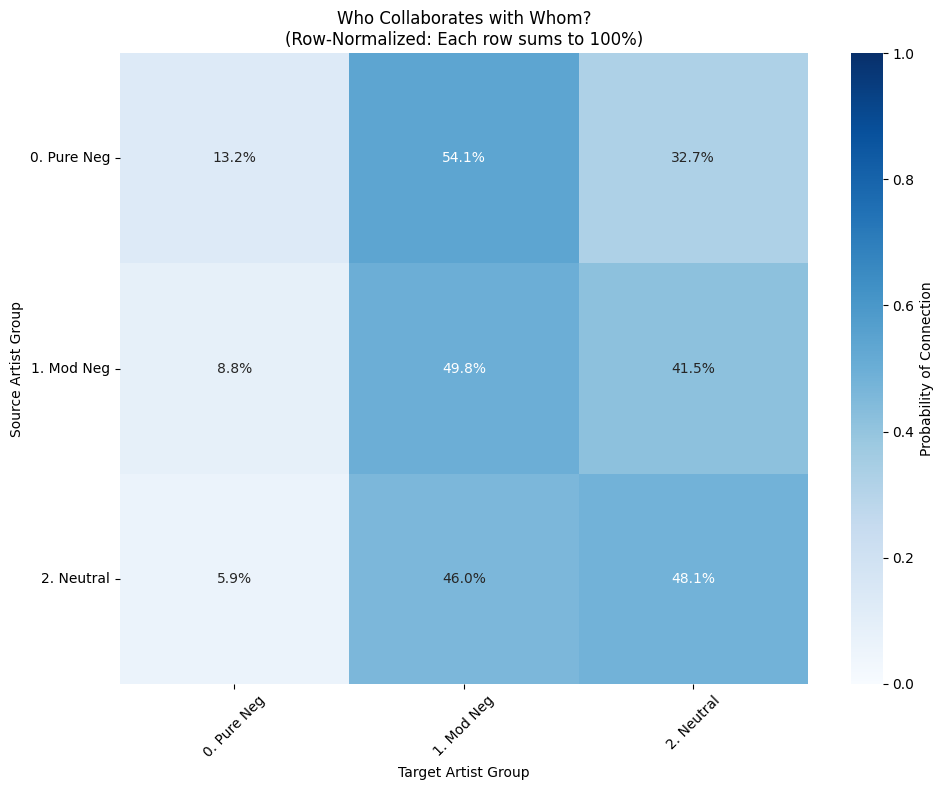

Raw Counts (for validation):
             0. Pure Neg  1. Mod Neg  2. Neutral
0. Pure Neg        340.0      1389.0       840.0
1. Mod Neg        1389.0      7882.0      6566.0
2. Neutral         840.0      6566.0      6854.0


In [5]:
import networkx as nx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- 1. PREPARE THE GRAPH ---
# We take the partition dict {node_id: 0, node_id: 4...} and save it to the graph
# This creates a NEW attribute called 'sentiment_group' on every node.
nx.set_node_attributes(G, sentiment_partition, "sentiment_group")

# --- 2. COMPUTE MIXING MATRIX ---
# Now we look at the 'sentiment_group' (0-4), NOT the raw 'sentiment_compound'
mixing_matrix = nx.attribute_mixing_matrix(
    G,
    "sentiment_group",
    mapping=None,  # Not needed, the values are already integers 0-4
    normalized=False
)

# Convert to DataFrame
# Ensure the index matches the actual groups found (0 to 4)
labels = ["0. Pure Neg", "1. Mod Neg", "2. Neutral", "3. Mod Pos", "4. Pure Pos"]

# Safety check: If a group is empty (e.g., no one is in group 2), the matrix might be smaller
# This ensures we match the shape dynamically
n_groups = mixing_matrix.shape[0]
current_labels = labels[:n_groups] 

df_mix = pd.DataFrame(mixing_matrix, index=current_labels, columns=current_labels)

# --- 3. NORMALIZE BY ROW (Probability) ---
# "Given a starting artist in Row X, what % of their links go to Column Y?"
# This handles the fact that Group 4 is huge.
row_sums = df_mix.sum(axis=1)
# Avoid division by zero if a group has 0 edges
df_percent = df_mix.div(row_sums.replace(0, 1), axis=0)

# --- 4. PLOT ---
plt.figure(figsize=(10, 8))
sns.heatmap(
    df_percent, 
    annot=True,       # Show the numbers
    fmt=".1%",        # Format as percent
    cmap="Blues",     # Blue color scheme
    cbar_kws={'label': 'Probability of Connection'},
    vmin=0, vmax=1    # Fix scale 0-100% for consistency
)

plt.title("Who Collaborates with Whom?\n(Row-Normalized: Each row sums to 100%)")
plt.ylabel("Source Artist Group")
plt.xlabel("Target Artist Group")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("Raw Counts (for validation):")
print(df_mix)

# Semantic partitioning

In [ ]:
import networkx as nx
import json
import numpy as np
from sklearn.cluster import KMeans
import community.community_louvain as community_louvain
from pathlib import Path

# --- 1. LOAD GRAPH ---
# Make sure this is the file where you SAVED the embeddings in step 1
G_path = Path(r"C:\Users\Madsl\Dropbox\DTU\Kand\2.semester\Socialgraphs_and_interactions\SocialGraphs\SocialGraphs\Project\MUSIC\artist_network_with_embeddings.graphml")

print(f"Loading {G_path}...")
G = nx.read_graphml(str(G_path))

# --- 2. PREPARE VECTORS ---
print("Extracting embedding vectors from nodes...")
node_ids = []
vectors = []

for node in G.nodes():
    # 1. Get the string attribute
    vec_str = G.nodes[node].get('lyric_vector')
    
    if vec_str:
        try:
            # 2. Convert JSON string back to Numpy Array
            vec = np.array(json.loads(vec_str))
            vectors.append(vec)
            node_ids.append(node)
        except:
            pass # Skip nodes with corrupted data

X = np.array(vectors)
print(f"Extracted {len(X)} vectors. Shape: {X.shape}")

# --- 3. DETERMINE 'K' (How many clusters?) ---
# To make a fair comparison, let's look at how many communities 
# the Structure (Louvain) naturally has, and use that same number for Lyrics.

louvain_partition = community_louvain.best_partition(G, weight='weight', random_state=42)
num_structural_communities = len(set(louvain_partition.values()))

print(f"Structural analysis (Louvain) found {num_structural_communities} communities.")
print(f"We will now group the Lyrics into {num_structural_communities} clusters to compare.")

# --- 4. CLUSTER EMBEDDINGS (K-MEANS) ---
# This groups artists purely by how similar their lyrics are (Cosine distance logic)
kmeans = KMeans(n_clusters=num_structural_communities, random_state=42, n_init=10)
labels = kmeans.fit_predict(X)

# Create the partition dictionary: {node_id: cluster_id}
lyric_partition = {node: int(label) for node, label in zip(node_ids, labels)}

# --- 5. CALCULATE MODULARITY ---
# We calculate Modularity on the ORIGINAL graph, but using the LYRIC groups.
# Q: "Do people in Lyrical Group 1 actually connect to each other?"

# Filter graph to only include nodes that actually had lyrics/embeddings
G_sub = G.subgraph(node_ids)

mod_lyrics = community_louvain.modularity(lyric_partition, G_sub, weight='weight')
mod_structure = community_louvain.modularity(louvain_partition, G, weight='weight')

print("\n" + "="*40)
print("       THE FINAL VERDICT")
print("="*40)
print(f"Structural Modularity (Louvain): {mod_structure:.4f}")
print(f"Lyrical Modularity (K-Means):    {mod_lyrics:.4f}")

if mod_lyrics > 0.1:
    print("\nResult: SIGNIFICANT.")
    print("Artists who write about similar topics DOES tend to collaborate.")
elif mod_lyrics > 0:
    print("\nResult: WEAK / RANDOM.")
    print("There is a tiny correlation, but genre/topic is not the main driver of collaboration.")
else:
    print("\nResult: NONE.")
    print("Lyrical similarity has zero impact on who collaborates with whom.")

Loading C:\Users\Madsl\Dropbox\DTU\Kand\2.semester\Socialgraphs_and_interactions\SocialGraphs\SocialGraphs\Project\MUSIC\artist_network_with_embeddings.graphml...
Extracting embedding vectors from nodes...
Extracted 983 vectors. Shape: (983, 384)
Structural analysis (Louvain) found 9 communities.
We will now group the Lyrics into 9 clusters to compare.


c:\Users\Madsl\anaconda3\envs\lyrics_project\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(



       THE FINAL VERDICT
Structural Modularity (Louvain): 0.4982
Lyrical Modularity (K-Means):    0.1190

Result: SIGNIFICANT.
Artists who write about similar topics DOES tend to collaborate.


In [14]:
from sklearn.metrics import adjusted_rand_score

# Create lists of labels aligned by node
common_nodes = [n for n in G.nodes() if n in lyric_partition]
struct_labels = [louvain_partition[n] for n in common_nodes]
lyric_labels = [lyric_partition[n] for n in common_nodes]

ari = adjusted_rand_score(struct_labels, lyric_labels)
print(f"\nSimilarity between Structure and Lyrics (ARI): {ari:.4f}")
# 1.0 = Perfect match (The social circles are exactly the lyrical circles)
# 0.0 = No relationship


Similarity between Structure and Lyrics (ARI): 0.0868


identifying lyrical themes...


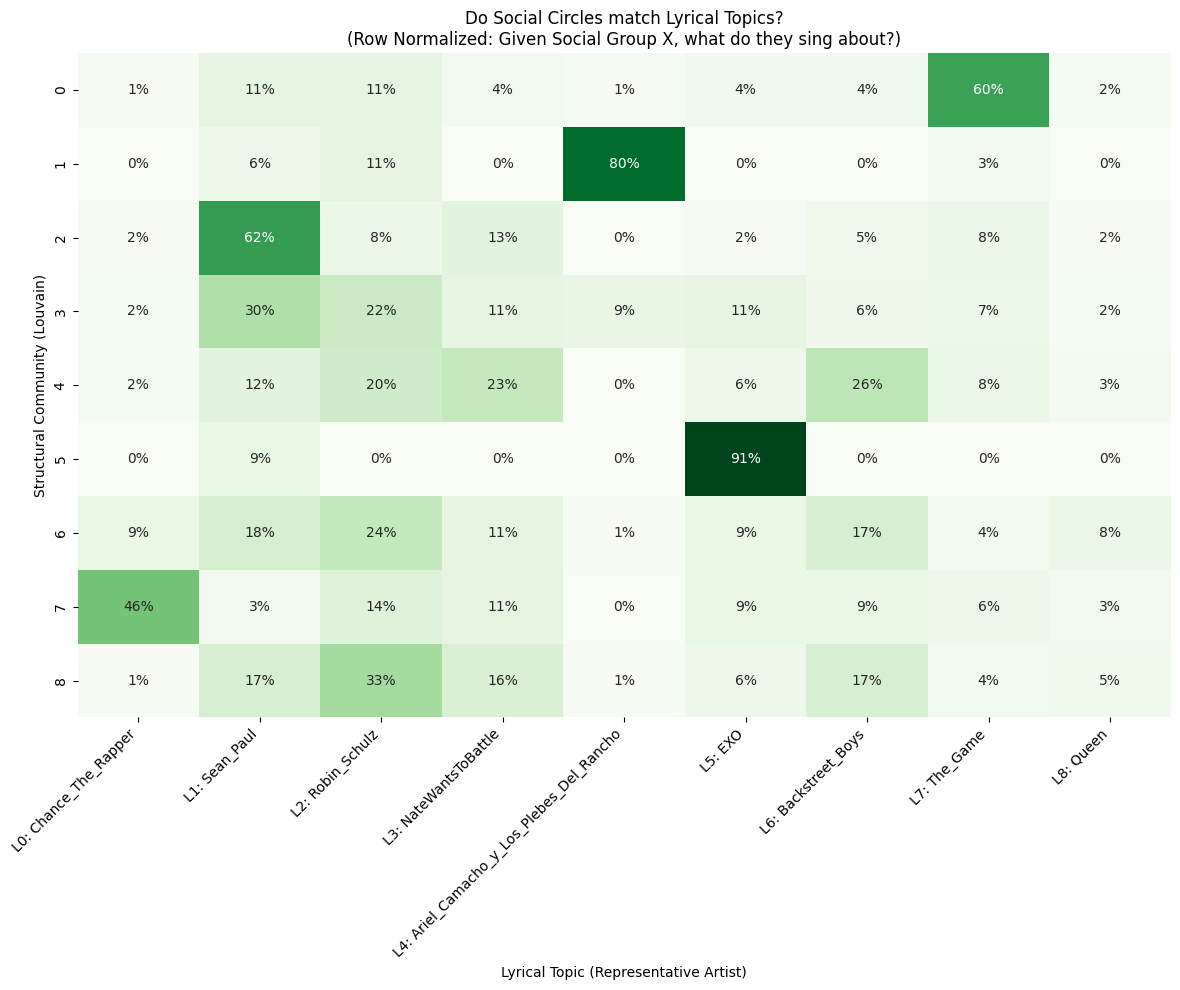

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

# --- 1. ALIGN DATA ---
# We need to make sure we are comparing the exact same nodes in the exact same order
common_nodes = [n for n in G.nodes() if n in lyric_partition and n in louvain_partition]

# Create a DataFrame for easy cross-tabulation
df_compare = pd.DataFrame({
    'Node': common_nodes,
    'Social_Cluster': [louvain_partition[n] for n in common_nodes],
    'Lyric_Cluster': [lyric_partition[n] for n in common_nodes]
})

# --- 2. IDENTIFY CLUSTER "THEMES" (Optional but helpful) ---
# To make the plot readable, let's find the "Representative Artist" for each Lyric Cluster.
# We find the node closest to the center of each K-Means cluster.

print("identifying lyrical themes...")
cluster_names = {}
unique_lyric_clusters = sorted(df_compare['Lyric_Cluster'].unique())

for clust_id in unique_lyric_clusters:
    # Get all vectors belonging to this cluster
    nodes_in_cluster = [n for n, l in lyric_partition.items() if l == clust_id]
    
    if not nodes_in_cluster:
        continue
        
    # Get the vectors
    # (We have to grab them from the graph again or X if indices match. 
    #  Safest way here is strictly by node ID)
    cluster_vectors = []
    valid_nodes = []
    for n in nodes_in_cluster:
        v_str = G.nodes[n].get('lyric_vector')
        if v_str:
            cluster_vectors.append(np.array(json.loads(v_str)))
            valid_nodes.append(n)
            
    if not cluster_vectors:
        continue

    # Calculate Centroid
    centroid = np.mean(cluster_vectors, axis=0)
    
    # Find the artist closest to the centroid
    dists = euclidean_distances([centroid], cluster_vectors)
    closest_idx = np.argmin(dists)
    rep_artist = valid_nodes[closest_idx]
    
    cluster_names[clust_id] = f"L{clust_id}: {rep_artist}"

# Update the dataframe with names
df_compare['Lyric_Label'] = df_compare['Lyric_Cluster'].map(cluster_names)


# --- 3. CREATE CONFUSION MATRIX ---
# Rows = Social Communities, Cols = Lyrical Topics
confusion = pd.crosstab(df_compare['Social_Cluster'], df_compare['Lyric_Label'])

# Normalize by Row (Social Cluster)
# "For Social Cluster X, what % of them sing about Topic Y?"
confusion_norm = confusion.div(confusion.sum(axis=1), axis=0)

# --- 4. PLOT ---
plt.figure(figsize=(12, 10))
sns.heatmap(confusion_norm, annot=True, fmt=".0%", cmap="Greens", cbar=False)

plt.title("Do Social Circles match Lyrical Topics?\n(Row Normalized: Given Social Group X, what do they sing about?)")
plt.ylabel("Structural Community (Louvain)")
plt.xlabel("Lyrical Topic (Representative Artist)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Further random analysis 

Loading C:\Users\Madsl\Dropbox\DTU\Kand\2.semester\Socialgraphs_and_interactions\SocialGraphs\SocialGraphs\Project\MUSIC\artist_network_with_embeddings.graphml...
Calculating Global Lyrical Average...
Analyzing Node Eccentricity and Sentiment...


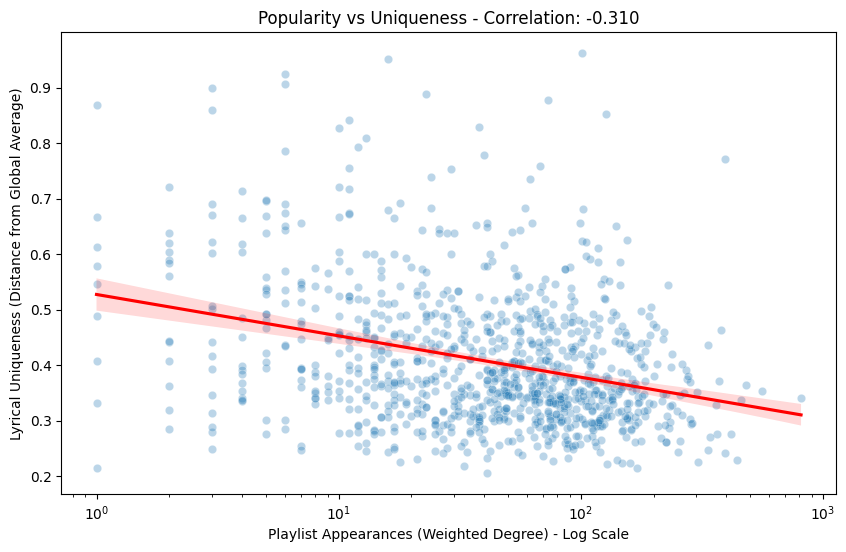

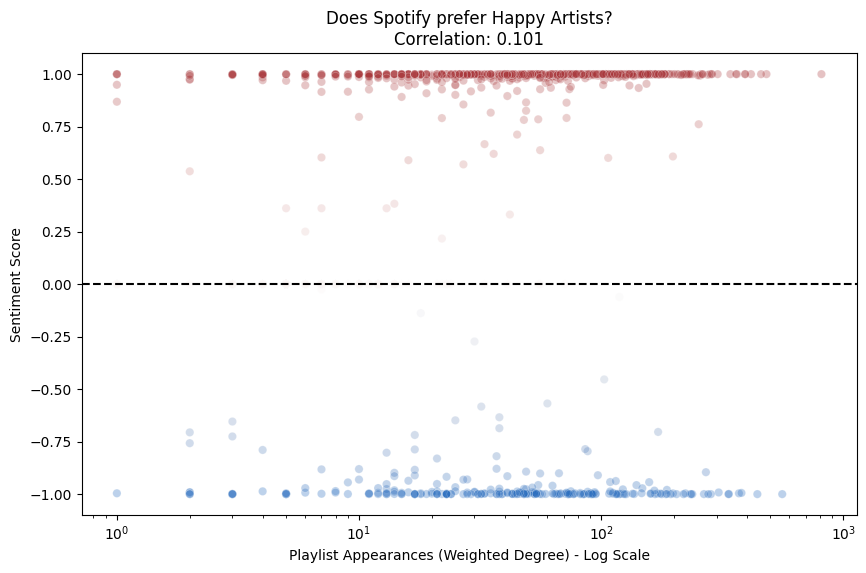


--- INSIGHTS ---
1. Lyrical Genericness:
   Negative Correlation (-0.31): Confirmed. Popular artists are significantly more generic.
2. Emotional Bias:
   Positive Correlation (0.10): Curators prefer HAPPY music.


In [6]:
import numpy as np
import networkx as nx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr
import networkx as nx
import json
import numpy as np
from sklearn.cluster import KMeans
import community.community_louvain as community_louvain
from pathlib import Path

# --- 1. LOAD GRAPH ---
# Make sure this is the file where you SAVED the embeddings in step 1
G_path = Path(r"C:\Users\Madsl\Dropbox\DTU\Kand\2.semester\Socialgraphs_and_interactions\SocialGraphs\SocialGraphs\Project\MUSIC\artist_network_with_embeddings.graphml")

print(f"Loading {G_path}...")
G = nx.read_graphml(str(G_path))
# --- 1. SETUP & RE-LOAD VECTORS ---
# Ensure G is loaded
if 'G' not in locals():
    # Load your file again if needed
    pass 

# Extract vectors and degrees
data_points = []
vectors = []
nodes_with_vecs = []

global_centroid = None

# Collect all vectors first to find the "Global Average"
print("Calculating Global Lyrical Average...")
all_vecs_list = []
for node in G.nodes():
    v_str = G.nodes[node].get('lyric_vector')
    if v_str:
        v = np.array(json.loads(v_str))
        all_vecs_list.append(v)

if all_vecs_list:
    # The "Generic Music" Vector (Average of all artists)
    global_mean_vec = np.mean(all_vecs_list, axis=0)
else:
    raise ValueError("No vectors found!")

print("Analyzing Node Eccentricity and Sentiment...")
for node in G.nodes():
    if 'lyric_vector' in G.nodes[node]:
        # 1. Get Degree (How popular is this artist in playlists?)
        deg = G.degree(node, weight='weight')
        
        # 2. Get Sentiment
        sent = float(G.nodes[node].get('sentiment_compound', 0))
        
        # 3. Calculate "Uniqueness" (Distance from the Global Average)
        # We use Cosine Distance (1 - similarity). 
        # 0 = Is the average. 1 = Totally different.
        vec = np.array(json.loads(G.nodes[node]['lyric_vector']))
        similarity = cosine_similarity([vec], [global_mean_vec])[0][0]
        dist = 1 - similarity
        
        data_points.append({
            'Artist': node,
            'Playlist_Popularity': deg,  # Use log scale in plot
            'Lyrical_Uniqueness': dist,  # High = Unique, Low = Generic
            'Sentiment': sent
        })

df = pd.DataFrame(data_points)

# --- PLOT 1: THE "MAINSTREAM SOUP" THEORY ---
# Does popularity kill uniqueness?
plt.figure(figsize=(10, 6))
# Log scale for popularity because degrees usually follow power laws
sns.scatterplot(data=df, x='Playlist_Popularity', y='Lyrical_Uniqueness', alpha=0.3)
plt.xscale('log') 

# Trendline
sns.regplot(data=df, x='Playlist_Popularity', y='Lyrical_Uniqueness', 
            scatter=False, color='red', logx=True)

corr1, _ = pearsonr(np.log1p(df['Playlist_Popularity']), df['Lyrical_Uniqueness'])

plt.title(f"Popularity vs Uniqueness - Correlation: {corr1:.3f}")
plt.xlabel("Playlist Appearances (Weighted Degree) - Log Scale")
plt.ylabel("Lyrical Uniqueness (Distance from Global Average)")
plt.show()

# --- PLOT 2: THE "SAD VS HAPPY" CURATOR BIAS ---
# Do curators prefer happy music?
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Playlist_Popularity', y='Sentiment', alpha=0.3, hue='Sentiment', palette="vlag")
plt.xscale('log')
plt.axhline(0, color='black', linestyle='--')

corr2, _ = pearsonr(np.log1p(df['Playlist_Popularity']), df['Sentiment'])
plt.title(f"Does Spotify prefer Happy Artists?\nCorrelation: {corr2:.3f}")
plt.xlabel("Playlist Appearances (Weighted Degree) - Log Scale")
plt.ylabel("Sentiment Score")
plt.legend([],[], frameon=False) # Hide legend
plt.show()

print("\n--- INSIGHTS ---")
print("1. Lyrical Genericness:")
if corr1 < -0.1:
    print(f"   Negative Correlation ({corr1:.2f}): Confirmed. Popular artists are significantly more generic.")
else:
    print(f"   No strong correlation ({corr1:.2f}). Niche artists can be just as generic as pop stars.")

print("2. Emotional Bias:")
if corr2 > 0.1:
    print(f"   Positive Correlation ({corr2:.2f}): Curators prefer HAPPY music.")
elif corr2 < -0.1:
    print(f"   Negative Correlation ({corr2:.2f}): Curators prefer SAD music.")
else:
    print("   No Correlation. Spotify loves happy and sad music equally.")